In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# A Simple Starter Code for the AJL Competition

@Cindy Deng

---


Hi! This starter code is designed to help you get familiar with basic Kaggle operations and guide you through the basic workflow of a machine learning project. 

The code outlines essential steps including data loading, preprocessing, model building, training, and generating predictions. Each section serves as a foundation, but there are many ways to enhance each step to improve your final model's accuracy. Feel free to experiment with different data augmentation techniques, model architectures, and tuning methods to optimize your final results! Some amazing tutorials are available through your AI Studio course in Canvas / in the 'Resource' section of this Kaggle competition.

Good luck and have fun!

---

## Note - About file path

You could use the cell above to print the names of the file directories and get the following directories:

```
/kaggle/input/bttai-ajl-2025/sample_submission.csv
/kaggle/input/bttai-ajl-2025/train.csv
/kaggle/input/bttai-ajl-2025/test.csv
/kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg
/kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg
...
...
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/11271bdf2598afdd4260db3125e1f6a5.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/732819951dcf2b53d15ea7b8bb123b71.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/6dcc7a8abb5e1c6e670101f4b6231246.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/e63c3b3f0ab8905e204fe467cc7411f9.jpg
...
...
```



## 1. Import Necessary Libraries

In [2]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [3]:
# 2. Load Data
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the  correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [4]:
counts = train_df.groupby(["label", "fitzpatrick_scale"]).size().unstack().fillna(0)
print(counts)

fitzpatrick_scale                     -1     1      2     3     4     5     6
label                                                                        
acne                                 0.0  32.0   48.0  22.0  15.0  11.0   0.0
acne-vulgaris                        0.0  53.0  104.0  34.0  30.0   9.0   4.0
actinic-keratosis                    5.0  21.0   55.0  18.0  15.0   8.0   0.0
basal-cell-carcinoma                 8.0  58.0  114.0  81.0  47.0  15.0   5.0
basal-cell-carcinoma-morpheiform     1.0  16.0   21.0   4.0   0.0   1.0   0.0
dermatofibroma                       1.0   9.0   25.0  16.0   4.0   0.0   0.0
dermatomyositis                      2.0  16.0   39.0  24.0  15.0   6.0   4.0
dyshidrotic-eczema                   4.0  12.0   18.0   9.0   8.0   2.0   5.0
eczema                               3.0  18.0   65.0  25.0  17.0   8.0   7.0
epidermal-nevus                      2.0  25.0   19.0   7.0   9.0   2.0   0.0
folliculitis                        20.0  20.0   72.0  63.0  33.

In [5]:
# Check the first few rows to understand the structure
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


In [6]:
# 3. Data Preprocessing
# Encode the labels -- translating diagnoses to numbers
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# # Define image data generators for training and validation
# train_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directory paths
train_dir = '/kaggle/input/bttai-ajl-2025/train/train/'

In [7]:

# FRom image processing colab

# Necessary Imports
import os
import numpy as np
import pandas as pd
from collections import Counter
import keras
from keras import Sequential
from keras import layers
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout, Input
from keras.optimizers import Adam
from PIL import Image
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from keras.preprocessing import image
import tensorflow as df

from sklearn.model_selection import train_test_split

from tqdm import tqdm

### Data Augmentation



In [8]:
###### METHODS FOR EACH AUGMENTATION
# Taken from data aug colab

from PIL import Image, ImageEnhance, ImageFilter

def rotate(filepath):
    with Image.open(filepath) as img:
        # print("Original Image: ")
        # display(img)
        
        rotated = img.rotate(45)
        # print("Rotated 45 degrees")
        # display(rotated)

    return rotated  

def flip_upside_down(filepath):
    with Image.open(filepath) as img:
        upside = img.transpose(Image.FLIP_TOP_BOTTOM)
    return upside

def brightness(filepath):
    with Image.open(filepath) as img:
        enhancer = ImageEnhance.Brightness(img)
        bright = enhancer.enhance(1.5)  # Increase brightness by 50%
    return bright

def light_blur(filepath):
    with Image.open(filepath) as img:
        light_blurred = img.filter(ImageFilter.GaussianBlur(radius=3))
    return light_blurred

def extreme_color(filepath):
    with Image.open(filepath) as img:
        color_enhancer = ImageEnhance.Color(img) # Creates a matrix for future enhancement
        extreme_color = color_enhancer.enhance(4.0) # The actual color enhancements
    return extreme_color

def noisy(filepath):
    with Image.open(filepath) as img:
        image_array = np.array(img)
        # up the sigma (25) here to adjust amnt of noise
        noise = np.random.normal(0, 25, image_array.shape)  # Generate random noise
        noisy_image = np.clip(image_array + noise, 0, 255).astype('uint8')  # Add noise and clip values
        noisy_image = Image.fromarray(noisy_image)
    return noisy_image


In [9]:
### Helper methods for all types of augmentation

import numpy as np
import os
import pandas as pd
import shutil
import random

from shutil import unpack_archive
from subprocess import check_output

## Introducing sampling methods to ensure that our dataset is proportional


def numImages(base_dir):
    """ Helper method that gives the number of images for each diagnosis """ 
    all_nums = []
    # Iterate through each subdirectory ('class_dir') in the base directory ('base_dir')
    for class_dir in tqdm(os.listdir(base_dir), desc="Processing classes"):
        class_path = os.path.join(base_dir, class_dir)

        # Get all filenames in the current class directory
        filenames = os.listdir(class_path)
        all_nums.append(len(filenames))
        print("class: ", class_dir, " number: ", len(filenames))

    print("Average number: ", sum(all_nums)/len(all_nums))

    return all_nums

""""
Selects samp_size files randomly from filenames.

If filter is True, checks to make sure none
are already augmented (e.g. have "-r" in the filename) (NOTE: tested this
and it doesn't seem like it makes a dif, so I've left it false by default for now)

NOTE: if there are not enough non-augmented images in the folder, returns
only as many images as can be augmented

filenames: list of names in the form <hash>.jpg
samp_size: int num of how many files from filenames to return
filter: whether to remove previously augmented files from sample

returns a list of filenames selected for augmentation
"""
def sample(filenames, samp_size, filter=False):
    
    if not filter:
        return random.sample(filenames, samp_size)

    to_aug = []
    inds_seen = set() # tracker for indexes of images iterated through

    # continuing to look until we either have enough images are have run out of images to select
    while len(to_aug) < samp_size and len(inds_seen) != len(filenames):
        ind = random.randint(0, len(filenames) - 1)
        if ind not in inds_seen:
            inds_seen.add(ind)
            if "-a" not in filenames[ind]:
                to_aug.append(filenames[ind])

    if len(to_aug) != samp_size:
        print("Did not find enough non-augmented images. Total number sampled: ", len(to_aug), ". Total number needed: ", samp_size)
    return to_aug

def chooseAugmentation(img):
    """ Helper that takes in a complete filepath to an image, performs a random augmentation, and returns the new image"""
    num = random.randint(0, 5)
    #[rotate, flip_upside_down, brightness, light_blur, extreme_color, noisy ]
    
    match status:
        case 0:
            print("0")
            return rotate(img)
        case 1:
            print("1")
            return flip_upside_down(img)
        case 2:
            print("2")
            return brightness(img)
        case 3:
            print("3")
            return light_blur(img)
        case 4:
            print("4")
            return extreme_color(img)
        case 5:
            print("5")
            return noisy(img)


def genAugmentation(class_path, to_aug, new_path):
    """
    generates needed number of images by randomly selecting images from a folder and
    performing an augmentation. Saves images to new_path folder.
    
    Parameters:
        class_path (string): The path to a directory of images
        to_aug (list of str): list of filenames to be augmented from class_path (in <hash>.jpg form, not full filepath) 
        new_path (string): new place where the images will be saved

    Returns:
        new_files: A list of the newly-generated augmented filenames
    """
    
    # list of new filepaths
    new_files = []

    # performing a 45-degree angle rotation
    for img in to_aug:
        imgpath = class_path + "/" + img
        if not os.path.exists(imgpath): # this is a previously augmented image and thus is in the new path
            imgpath = new_path + "/" + img
        #new_img = rotate(imgpath)
        new_img = flip_upside_down(imgpath)
        # removing jgp first to add -a inside of it
        # md_only = re.sub(".jpg", "", img)
        # print("Image name being added: ", f"{md_only}-a.jpg")
        # new_name = f"{md_only}-a.jpg"
        new_name = f"{re.sub('.jpg', '', img)}-a.jpg"
        while os.path.exists(os.path.join(new_path, new_name)):
            new_name = f"{re.sub('.jpg', '', new_name)}-a.jpg" # adding ANOTHER a until its a new version
        if os.path.exists(os.path.join(new_path, new_name)):
            print("Overwriting image: ", os.path.join(new_path, new_name))
        new_img.save(os.path.join(new_path, new_name)) # '-a' for augmented
        new_files.append(new_name)

    return new_files

In [10]:
### Implementations of different types of augmentation (basic upsample/downsample by cat)

def downsample(base_dir, sample_size_per_class, new_dir):
    """
    Draws a uniform sample of filenames from directories, where each directory represents a class.
    Copies sampled files into new_dir in the same class-based format as original
    
    Parameters:
        base_dir (str): The path to the base directory containing subdirectories.
        sample_size_per_class (int): The number of filenames to sample from each class directory.

    Returns:
        dict: A dictionary with class labels (directory names) as keys and lists of sampled filenames as values.
    """
    # Dictionary to store sampled filenames for each class
    sampled_files = {}
    new_path = "./" + new_dir

    # making new directory for sampled files
    if not os.path.exists(new_path):
        shutil.os.mkdir(new_path)

    # Iterate through each subdirectory ('class_dir') in the base directory ('base_dir')
    for class_dir in tqdm(os.listdir(base_dir), desc="Processing classes"):
        class_path = os.path.join(base_dir, class_dir)

        # Get all filenames in the current class directory
        filenames = os.listdir(class_path)

        # Check if there are enough files to sample from
        if len(filenames) < sample_size_per_class:
            print(f"Warning: Not enough files in class '{class_dir}' to sample {sample_size_per_class}. Using all available files.")
            sampled_files[class_dir] = filenames
        else:
            # Randomly sample files from the current class directory
            sampled_files[class_dir] = random.sample(filenames, sample_size_per_class)

        # moving files into the new training folder named after the class label
        if not os.path.exists(new_path + "/" + class_dir):
            shutil.os.mkdir(new_path + "/" + class_dir)
        for file in sampled_files[class_dir]:
            if not os.path.exists(new_path + "/" + class_dir + "/" + file):
                shutil.copy2(class_path + "/" + file, new_path + "/" + class_dir)

    return sampled_files

def upsample(base_dir, samp_size, new_dir):
    """
    Upsamples by identifying the number of additional images needed in each class 
    and randomly generating augmented images to fill this gap.
    Also copies the new files into new_dir in the same class-folder format. 
    
    Parameters:
        base_dir (str): The path to the base directory containing subdirectories.
        samp_size (int): The number of filenames to sample from each class directory.

    Returns: nothing
    
    """
    new_path = "./" + new_dir

    # making new directory for sampled files
    if not os.path.exists(new_path):
        shutil.os.mkdir(new_path)
        
    # Iterate through each subdirectory ('class_dir') in the base directory ('base_dir')
    for class_dir in tqdm(os.listdir(base_dir), desc="Processing classes"):
        class_path = os.path.join(base_dir, class_dir)

        # making class directory in new dataset if needed
        if not os.path.exists(new_path + "/" + class_dir):
            shutil.os.mkdir(new_path + "/" + class_dir)

        # Get all filenames in the current class directory
        filenames = os.listdir(class_path)
        all_new_files = [] # this will be the list of files to save to the new directory
        cur_files = filenames # list of current files to chose from when augmenting

        # Check if we need to increase sample size
        if len(filenames) < samp_size:
            # generate additional images and add them to the new folder
            to_select = samp_size - len(filenames)
            while to_select > 0:
                actual_select = to_select if len(cur_files) >= to_select else len(cur_files)
                to_augment = sample(cur_files, actual_select)
                new_c_files = genAugmentation(class_path, to_augment, new_path + "/" + class_dir)
                all_new_files.extend(new_c_files)
                cur_files.extend(new_c_files)
                to_select -= actual_select 
            
        """
        while to_select > 0:
                actual_select = to_select if len(this_fitz) >= to_select else len(this_fitz)
     
                # now randomly select to_select codes from the train df and add them to to_augment
                to_augment = sample(all_cat_fitz_files, actual_select)
                new_cf_files = (genAugmentation(base_dir + "/" + cat, to_augment, new_dir +  "/" + cat))
                new_files.extend(new_cf_files)
                all_cat_fitz_files.extend(new_cf_files)
                to_select -= actual_select
        
        """
            
        # add all original files to the new folder
        # moving files into the new training folder named after the class label

        for file in filenames:
            if not os.path.exists(new_path + "/" + class_dir + "/" + file):
                shutil.copy2(class_path + "/" + file, new_path + "/" + class_dir)

In [11]:
### setting up upsampling by skin color/fitz

import re

""" 
returns a list of count by fitz score for each category. 
base_dir = train_dir or equiv
this is done like this and not with the df because of the case where
we add new data to the directory (augmented -r files) that won't be in the CSV
"""
def count_by_diag(base_dir, train_df):
    for diag_dir in os.listdir(base_dir):
        fitz_count = [0 for i in range(7)] # ignoring -1 for now (these could also be filtered out entirely??)
        dir_path = os.path.join(base_dir, diag_dir)
        for img in os.listdir(dir_path):
            
            # using filename check fitz score in df
            
            # accounting for augmented images, which ahve the same score as their original version
            if "-a" in img:
                img = re.sub("-a", "", img)
                
            fitz = train_df[train_df["md5hash"] == img]["fitzpatrick_scale"].iloc[0]
            if fitz != -1:
                fitz_count[fitz] += 1

        print(diag_dir, ": ", fitz_count)

def fitz_diagnosis_upsample(base_dir, new_dir, train_df):
    """
    for each category:
    - find largest fitz cat and mult by 6 to get total number desired
    - randomly select X number of images in each category and add all md5hashes to a list
    - collect this list over all categories, then after doing so do all of the augmentations on this list
    - THEN do the regular by-category upsampling 
    """
    # list of string diags to use in filepath later
    ordered_cats = train_df["label"].unique()
    ordered_cats.sort()

    new_files = [] # list of all images augmented

    # making new_path directory in new dataset if needed
    if not os.path.exists(new_dir):
        shutil.os.mkdir(new_dir)
   
    for cat in ordered_cats:

        # making class directory in new dataset if needed
        if not os.path.exists(new_dir + "/" + cat):
            shutil.os.mkdir(new_dir + "/" + cat)
            
        # to_augment = [] # list of md5hash.jpg keys to augment
        most_common = max((train_df[train_df["label"] == cat])['fitzpatrick_scale'].value_counts(normalize=False))
        goal_total = most_common * 6

        for i in range(1, 7): #iterating through fitz scores
            # all files of this fitz score in the given cat
            this_fitz = train_df[(train_df["label"]== cat) & (train_df["fitzpatrick_scale"]==i)]

            # all files in the original directory that have a specific fitz score
            # exists to compile additional augmented files to be selected for later additional augmentations, 
            # e.g. might include <hash>.jpg and <hash>-a.jpg
            all_cat_fitz_files = this_fitz["md5hash"].to_list()

            if len(this_fitz) == 0:
                print("Category " + cat + " has no images for fitz " + str(i))
                continue
            # num of files we need to augment  
            to_select = most_common - len(this_fitz)
            
            # continue to randomly sample as many files as needed to reach goal number
            while to_select > 0:
                actual_select = to_select if len(all_cat_fitz_files) >= to_select else len(all_cat_fitz_files)
     
                # now randomly select to_select codes from the train df and add them to to_augment
                to_augment = sample(all_cat_fitz_files, actual_select)
                new_cf_files = (genAugmentation(base_dir + "/" + cat, to_augment, new_dir +  "/" + cat))
                new_files.extend(new_cf_files)
                all_cat_fitz_files.extend(new_cf_files)
                to_select -= actual_select
                
        # new_files = genAugmentation(base_dir + "/" + cat, to_augment, new_dir +  "/" + cat)
        # print("New files: ", new_files)
        # adding ALL original images to the new folder
        folder = base_dir + "/" + cat + "/"
        for hsh in train_df[train_df["label"] == cat]["md5hash"]:
            if not os.path.exists( new_dir + "/" + cat + "/" + hsh):
                shutil.copy2(folder + hsh, new_dir + "/" + cat)

In [12]:
# shutil.rmtree("./test_fitz")

In [13]:
# # testing above methods
count_by_diag(train_dir, train_df)
fitz_diagnosis_upsample(train_dir, "./test_fitz", train_df)
print("NEW DIR: ")
count_by_diag("./test_fitz", train_df)
# shutil.rmtree("./test_fitz")

dermatomyositis :  [0, 16, 39, 24, 15, 6, 4]
malignant-melanoma :  [0, 23, 29, 10, 7, 3, 1]
basal-cell-carcinoma :  [0, 58, 114, 81, 47, 15, 5]
eczema :  [0, 18, 65, 25, 17, 8, 7]
basal-cell-carcinoma-morpheiform :  [0, 16, 21, 4, 0, 1, 0]
melanoma :  [0, 27, 55, 41, 24, 15, 7]
acne :  [0, 32, 48, 22, 15, 11, 0]
kaposi-sarcoma :  [0, 10, 18, 21, 29, 21, 8]
seborrheic-keratosis :  [0, 9, 21, 6, 4, 3, 4]
keloid :  [0, 16, 23, 17, 19, 20, 12]
acne-vulgaris :  [0, 53, 104, 34, 30, 9, 4]
squamous-cell-carcinoma :  [0, 71, 121, 86, 50, 34, 14]
epidermal-nevus :  [0, 25, 19, 7, 9, 2, 0]
pyogenic-granuloma :  [0, 25, 27, 12, 10, 3, 0]
dyshidrotic-eczema :  [0, 12, 18, 9, 8, 2, 5]
mycosis-fungoides :  [0, 26, 38, 30, 18, 9, 2]
actinic-keratosis :  [0, 21, 55, 18, 15, 8, 0]
superficial-spreading-melanoma-ssm :  [0, 35, 28, 12, 2, 2, 2]
dermatofibroma :  [0, 9, 25, 16, 4, 0, 0]
folliculitis :  [0, 20, 72, 63, 33, 22, 9]
prurigo-nodularis :  [0, 6, 24, 24, 37, 22, 5]
Category acne has no images fo

In [14]:
counts_after = train_df.groupby(["label", "fitzpatrick_scale"]).size().unstack().fillna(0)
print(counts_after)

fitzpatrick_scale                     -1     1      2     3     4     5     6
label                                                                        
acne                                 0.0  32.0   48.0  22.0  15.0  11.0   0.0
acne-vulgaris                        0.0  53.0  104.0  34.0  30.0   9.0   4.0
actinic-keratosis                    5.0  21.0   55.0  18.0  15.0   8.0   0.0
basal-cell-carcinoma                 8.0  58.0  114.0  81.0  47.0  15.0   5.0
basal-cell-carcinoma-morpheiform     1.0  16.0   21.0   4.0   0.0   1.0   0.0
dermatofibroma                       1.0   9.0   25.0  16.0   4.0   0.0   0.0
dermatomyositis                      2.0  16.0   39.0  24.0  15.0   6.0   4.0
dyshidrotic-eczema                   4.0  12.0   18.0   9.0   8.0   2.0   5.0
eczema                               3.0  18.0   65.0  25.0  17.0   8.0   7.0
epidermal-nevus                      2.0  25.0   19.0   7.0   9.0   2.0   0.0
folliculitis                        20.0  20.0   72.0  63.0  33.

In [15]:
## getting a sense of how many images are in each category
numImages("./test_fitz")

## --> min number we can choose is 85 for basal-cell-carcinoma-morpheiform


Processing classes: 100%|██████████| 21/21 [00:00<00:00, 1544.38it/s]

class:  kaposi-sarcoma  number:  176
class:  seborrheic-keratosis  number:  127
class:  dermatomyositis  number:  236
class:  pyogenic-granuloma  number:  137
class:  epidermal-nevus  number:  127
class:  mycosis-fungoides  number:  232
class:  folliculitis  number:  452
class:  actinic-keratosis  number:  280
class:  prurigo-nodularis  number:  223
class:  acne-vulgaris  number:  624
class:  keloid  number:  140
class:  eczema  number:  393
class:  basal-cell-carcinoma-morpheiform  number:  85
class:  dermatofibroma  number:  101
class:  acne  number:  240
class:  dyshidrotic-eczema  number:  112
class:  melanoma  number:  342
class:  basal-cell-carcinoma  number:  692
class:  squamous-cell-carcinoma  number:  757
class:  malignant-melanoma  number:  179
class:  superficial-spreading-melanoma-ssm  number:  212
Average number:  279.3809523809524


[176,
 127,
 236,
 137,
 127,
 232,
 452,
 280,
 223,
 624,
 140,
 393,
 85,
 101,
 240,
 112,
 342,
 692,
 757,
 179,
 212]

In [16]:
# shutil.rmtree("./upsampled")

In [17]:
### Down and/or upsampling

# creating a new training folder with sampled images
#sample_dict = downsample(train_dir, 40)

# min number is 43, so for now bc we're only at most doubling we'll do upsampling up to 85
upsample("./test_fitz", 400, "upsampled")

Processing classes: 100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


In [18]:
# SECOND ROUND OF AUGMENTATION -- can also try inc. sample size in second round

#fitz_diagnosis_upsample(train_dir, "./test_fitz", train_df)
#upsample("./test_fitz", 100, "upsampled")

In [19]:
numImages("./upsampled")

Processing classes: 100%|██████████| 21/21 [00:00<00:00, 1498.22it/s]

class:  kaposi-sarcoma  number:  333
class:  seborrheic-keratosis  number:  321
class:  dermatomyositis  number:  305
class:  pyogenic-granuloma  number:  342
class:  epidermal-nevus  number:  337
class:  mycosis-fungoides  number:  323
class:  folliculitis  number:  452
class:  actinic-keratosis  number:  340
class:  prurigo-nodularis  number:  319
class:  acne-vulgaris  number:  624
class:  keloid  number:  369
class:  eczema  number:  398
class:  basal-cell-carcinoma-morpheiform  number:  358
class:  dermatofibroma  number:  354
class:  acne  number:  326
class:  dyshidrotic-eczema  number:  346
class:  melanoma  number:  376
class:  basal-cell-carcinoma  number:  692
class:  squamous-cell-carcinoma  number:  757
class:  malignant-melanoma  number:  299
class:  superficial-spreading-melanoma-ssm  number:  286
Average number:  393.1904761904762


[333,
 321,
 305,
 342,
 337,
 323,
 452,
 340,
 319,
 624,
 369,
 398,
 358,
 354,
 326,
 346,
 376,
 692,
 757,
 299,
 286]

In [20]:
image_size = (180, 180)  # Target dimensions for resizing images (height, width).
batch_size = 32  # Number of images processed in a single batch during training.
# Note: A batch size of 128 (common in other setups) may exceed Colab's memory limits, causing crashes.
# The chosen batch size of 32 balances memory usage and runtime, with an estimated runtime of ~3 hours.

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "./upsampled", #train_dir,             # Path to the directory containing the dataset.
    labels="inferred", # tells model to use folder names as labels
    label_mode="int",
    validation_split=0.2,    # Specify that 20% of the dataset will be used for validation.
    subset="both",           # Create both training and validation datasets from the directory.
    seed=42,                 # Random seed to ensure reproducibility when shuffling the data.
    image_size=image_size,   # Resize all images to the specified dimensions (180x180).
    batch_size=batch_size,   # Divide the dataset into batches of the specified size (32 images per batch).
)

# train_dir = '/kaggle/input/bttai-ajl-2025/train/train/'

# /kaggle/input/bttai-ajl-2025/test/test

test_dir = "/kaggle/input/bttai-ajl-2025/test"

# print(os.listdir(test_dir))

test_dataset = keras.utils.image_dataset_from_directory(
           test_dir,
           shuffle=False,        #or False
           batch_size=batch_size,
           image_size=image_size
)

Found 8257 files belonging to 21 classes.
Using 6606 files for training.
Using 1651 files for validation.
Found 1227 files belonging to 1 classes.


In [21]:
## transfer learning example
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model as the base model for transfer learning
base_model = keras.applications.Xception(
    weights="imagenet",  # Use weights pre-trained on the ImageNet dataset.
    input_shape=(180, 180, 3),  # Define the input shape expected by the base model.
    include_top=False,  # Exclude the fully connected classifier layers at the top.
)

# Freeze the base model's layers to prevent them from being updated during training.
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Keep first layers frozen
    layer.trainable = False

# Define the input for the new model
inputs = keras.Input(shape=(180, 180, 3))  # Input layer for images.

# Add a rescaling layer to preprocess the input images.
# Pre-trained InceptionV3 requires input values to be scaled from (0, 255) to (-1, 1).
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# Pass the rescaled input through the base model.
x = base_model(x, training=False)

# Apply global average pooling to reduce the spatial dimensions of the feature maps.
x = keras.layers.GlobalAveragePooling2D()(x)

# Add a dropout layer to prevent overfitting
x = keras.layers.Dropout(0.2)(x)

# Add a dense (fully connected) output layer with regularization
outputs = keras.layers.Dense(21, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.05))(x)

# Create the complete model
model = keras.Model(inputs, outputs)

# Display the model's architecture
model.summary(show_trainable=True)

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    early_stopping,
    reduce_lr
]

import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        cross_entropy = K.binary_crossentropy(y_true, y_pred)
        weight = alpha * K.pow((1 - y_pred), gamma)
        return weight * cross_entropy
    return loss

# Compile the model
from tensorflow.keras.optimizers import AdamW
model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5), #changed
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df['encoded_label']),
    y=train_df['encoded_label']
)

class_weight_dict = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    callbacks=callbacks,
    validation_data=val_ds,
    class_weight=class_weight_dict
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 180, 180, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 180, 180, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 6, 6, 2048)           │    20,861,480 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 21)                   │        43,029 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,904,509 (79.74 MB)

 Trainable params: 8,983,381 (34.27 MB)

 Non-trainable params: 11,921,128 (45.48 MB)

Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 64s 201ms/step - acc: 0.2269 - loss: 4.9234 - val_acc: 0.5167 - val_loss: 3.0600 - learning_rate: 1.0000e-04
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - acc: 0.6277 - loss: 2.6258 - val_acc: 0.7159 - val_loss: 2.1564 - learning_rate: 1.0000e-04
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - acc: 0.7713 - loss: 1.7705 - val_acc: 0.7704 - val_loss: 1.6716 - learning_rate: 1.0000e-04
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - acc: 0.8419 - loss: 1.2737 - val_acc: 0.8092 - val_loss: 1.3339 - learning_rate: 1.0000e-04
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - acc: 0.8935 - loss: 0.9374 - val_acc: 0.8292 - val_loss: 1.0957 - learning_rate: 1.0000e-04
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - acc: 0.9259 - loss: 0.7064 - val_acc: 0.8419 - val_loss: 0.9425 - learning_rate: 1.0000e-04
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - acc: 0.9538 - loss: 0.5485 - val_acc: 0.8516 - va

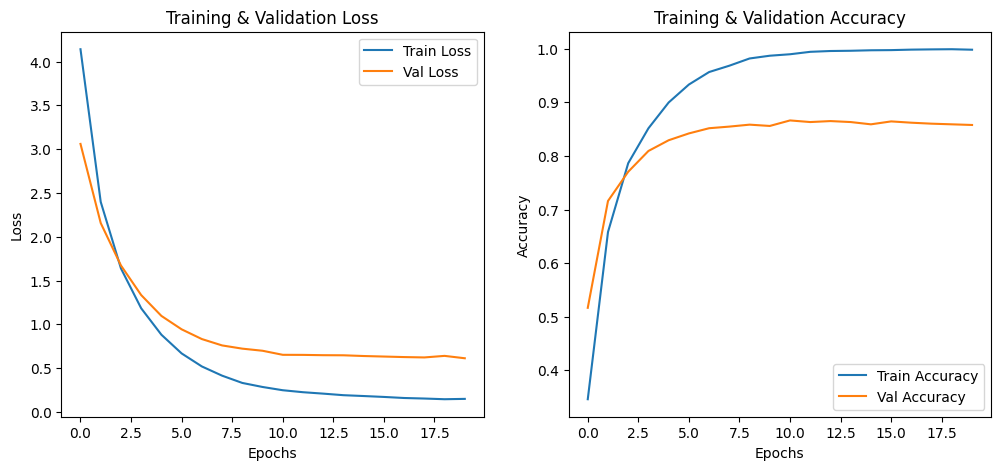

In [22]:
#### plotting training & validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [23]:
# # evaluating performance on test dataset

preds = model.predict(test_dataset, verbose="auto", steps=None, callbacks=None)

pred_class = np.argmax(preds, axis=1)

# print(pred_class[0:10])

# getting label -> integer label mapping from training data

class_names = train_ds.class_names  # Get class names in order
label_mapping = {idx: name for idx, name in enumerate(class_names)}  # Map name to index
# print("labels: ", label_mapping)
# now creating CSV with <hash>, <string label>
file_paths = test_dataset.file_paths
filenames = [os.path.splitext(os.path.basename(fp))[0] for fp in file_paths]
# print(filenames[0:10])
results = []

for i in range(len(filenames)):
    results.append({"md5hash": filenames[i], "label": label_mapping[pred_class[i]]})

results = pd.DataFrame(results)

print(results.head)

results.to_csv('submission.csv', index=False)  

39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step
<bound method NDFrame.head of                                md5hash                    label
0     000e8dd5ee75dd6668e978e7a4e6fe54             folliculitis
1     0097275da3cb707415d13d2c59cf8c8c          dermatomyositis
2     009c75339a21bb84a6425be6a95938d6        mycosis-fungoides
3     016abe4884715af85cd3f309f93b9641  squamous-cell-carcinoma
4     018504389f4fa566232eb6e3ff838cb8  squamous-cell-carcinoma
...                                ...                      ...
1222  fe0d0f2a52c0dd67cdeef523867e4a0b  squamous-cell-carcinoma
1223  feb23b8d752fc437b2dc3c9816c647ac          dermatomyositis
1224  fedcb4729515d8c9a11d2dbe88576773        mycosis-fungoides
1225  ff02c1d8ed5d771bd450877d2d1658ce       dyshidrotic-eczema
1226  ffd2a9f7fe88af2fc987ddb7a06c9069           kaposi-sarcoma

[1227 rows x 2 columns]>


## DO NOT USE -- Second model version with manual image conversion

In [24]:
# # preprocessing

# """
# Steps here:
# - iterate through all images in all of the directories of train
# - convert them to an array and add it to a dataframe with the ID being the hashcode
# - add this column to the original dataframe, matched by ID

# --> current version reduces image size significantly, which i think is fine for now
# --> i think maybe it's best to try the original model but with this dataset? alternatively choosing maybe relu instaed 
# of sigmoid in final step to choose exactly one label? or just choose the one with the highest prob from sigmoid

# --> SHAPE ON MODEL.FIT MIGHT NOT BE RIGHT BC EXPECTING ONE_HOT ENCODED LABELS 
# """

# width = 180
# height = 180
# X = []
# X_filenames = []

# # (folder name, list of directories, list of files)

# dircs = [i for i in os.walk(train_dir)]
# # print(dircs)
# for i in range(1, len(dircs)):
#     folder_path = dircs[i][0]
#     for j in range(len(dircs[i][2])):
#         path = folder_path + "/" + dircs[i][2][j]; # Construct the file path for the current image using the `Id` column from the DataFrame.
#         # print(path)
#         img = image.load_img(path, target_size=(width, height, 3))
#         # Load the image file from the constructed path.
#         # Resize the image to the target dimensions (180x180) with 3 channels (RGB).
        
#         img = image.img_to_array(img)
#         # Convert the loaded image into a NumPy array for numerical processing.
        
#         img = img / 255.0
#         # Normalize the pixel values to the range [0, 1] by dividing by 255.0.
#         # This is a common preprocessing step for deep learning models to improve training stability.
        
#         X.append(img)
#         X_filenames.append(dircs[i][2][j])
        
#         # Append the processed image array to the list `X`.

        
# X = np.array(X)
# X_filenames = np.array(X_filenames)
# # Convert the list of processed images into a NumPy array.
# # This ensures the data is in a format suitable for input to a deep learning model.

In [25]:
# # building a dataset in the form (input, labels)

# # first column is second column of X
# # second column is train_df['labels'] but in the correct order

# # print(X_filenames[0:10])

# inputs = [] 

# for i in train_df['md5hash']:
#     idx = np.where(X_filenames == i) # getting the index of the correct image
#     # print("label: ", i, " and index: ", idx)
#     img = X[idx] # actual image array
#     inputs.append(img)

# inputs = np.array(inputs)

# # create a tf.data.Dataset to feet into model.fit()
# X_train,X_test,y_train,y_test=train_test_split(inputs, train_df['label'],test_size=0.2)
# train_data = tf_data.Dataset.from_tensor_slices((X_train, y_train))
# val_data = tf_data.Dataset.from_tensor_slices((X_test, y_test))

In [26]:
# # building model

# # Initialize a Sequential model, which allows layers to be added one after another.
# model = Sequential()

# # Add an Input layer, specifying the shape of a single training example (e.g., an image).
# # model.add(keras.Input(shape=X_train[0].shape))
# inp_shape = image_size + (3,)
# model.add(keras.Input(shape=inp_shape))

# # Add the first convolutional layer with 16 filters, a 3x3 kernel, and ReLU activation.
# model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
# # This layer detects basic features like edges and corners in the input image.

# # Add a Batch Normalization layer to normalize the output of the Conv2D layer.
# model.add(BatchNormalization())
# # This stabilizes and accelerates training by reducing internal covariate shift.

# # Add a MaxPooling layer to reduce spatial dimensions by taking the maximum value in 2x2 regions.
# model.add(MaxPool2D(2, 2))
# # This reduces computational complexity and focuses on the most prominent features.

# # Add a Dropout layer to randomly drop 30% of neurons during training.
# model.add(Dropout(0.3))
# # This helps prevent overfitting by reducing reliance on specific neurons.

# # Add the second convolutional block (Conv2D -> BatchNormalization -> MaxPooling -> Dropout).
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# # Increase the number of filters to 32 for detecting more complex features.
# model.add(BatchNormalization())
# model.add(MaxPool2D(2, 2))
# model.add(Dropout(0.3))

# # Add the third convolutional block with 64 filters.
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# # Further increases the number of filters to detect even more complex patterns.
# model.add(BatchNormalization())
# model.add(MaxPool2D(2, 2))
# model.add(Dropout(0.4))  # Increase dropout rate to 40% to further reduce overfitting risk.

# # Flatten the output of the previous layer to convert the 3D feature maps into a 1D vector.
# model.add(Flatten())
# # This prepares the data for input into dense (fully connected) layers.

# # Add a Dense (fully connected) layer with 128 neurons and ReLU activation.
# model.add(Dense(128, activation='relu'))
# # This layer learns high-level combinations of the features extracted by the Conv2D layers.
# model.add(BatchNormalization())  # Normalize the output to stabilize training.
# model.add(Dropout(0.5))  # Apply a 50% dropout rate for strong regularization.

# # Add the final Dense layer with 25 neurons and sigmoid activation.
# model.add(Dense(25, activation='sigmoid'))
# # The output layer has 25 neurons, each representing a class in a multi-label classification problem.
# # Sigmoid activation is used to output probabilities for each class, as multiple classes can be "on."

# # The model is now ready to be compiled and trained.

In [27]:
# # for first version

# model.compile(optimizer='adam',loss= keras.losses.SparseCategoricalCrossentropy(
#         from_logits=True,
#         ignore_class=None,
#         reduction="sum_over_batch_size",
#         name="sparse_categorical_crossentropy",
#         dtype=None,
#     ),metrics=['accuracy'])

# history = model.fit(train_data,epochs=5,validation_data=val_data)

In [28]:
# score = model.evaluate(X_test, y_test, verbose = 0 )
# print("Test Score: ", score[0])
# print("Test accuracy: ", score[1])

## 4. Build the model


In [29]:
# TODO: You should implement the model architecture here.
# Feel free to explore different model types that best serve your purpose.

## 5. Train the Model


In [30]:
# TODO: Train your model here. 

## 6. Make Predictions on Test Data

In [31]:
# # 6. Make Predictions on Test Data
# # def preprocess_test_data(test_df, directory):
# """
# Template for loading and preprocessing test images.
# """
# # TODO: create a generator for the test set here.
# # test_datagen = ImageDataGenerator(rescale=1./255)
# # test_generator = test_datagen.flow_from_dataframe(
# #     .... ## set the test_generator here 
# # )
# # return test_generator


In [32]:
# # Load test data
# test_dir = '/kaggle/input/bttai-ajl-2025/test/test/'
# # test_generator = preprocess_test_data(test_df, test_dir)

## 7. Generate Predictions

In [33]:
# TODO
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission